Dieser Anhang ist ein \texttt{Jupyter Notebook}.
Hier wird eine mögliche Implementation des präsentierten Algorithmus vorgeführt.
Der Quellcode wurde in \texttt{Python 3.7.9} geschrieben und ausgeführt. 

Im nächsten Block werden die notwendigen Pakete importiert.

In [130]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from scipy.fft import ifft
from scipy.fft import fft
from scipy.interpolate import interp1d
from scipy.optimize import minimize

# increase matplotlib figure resolution
matplotlib.rcParams['figure.dpi'] = 1000
plt.rcParams["figure.figsize"] = (6.299213, 3.149606) # 16cm by 8cm

## Rauschformungsfilter

Der Filter wird als FIR Filter anhand von ISO226 konstruiert.
Der Ablauf besteht wie folgt:

1. ISO226 Frequenzverlauf für 0 Phon erstellen
2. Frequenzverlauf auf das gesamte Spektrum (bis $\frac{f_s}{2}$) extrapolieren
3. Wertemenge der Extrapolation limitieren
4. Verstärkung und Reduktion über das Spektrum numerisch bestimmen und auf 0 optimieren
5. FIR Kernel durch Inverse-Fourier Transformation bestimmen
6. Kernel durch Fenster fertigstellen

Jeder aufgeführte Schritt ist in einem eigenen Codeblock gegeben.

### Psychoakustische Zielfunktion nach ISO erstellen

Diese Implementation ist dem Standard entnommen und lediglich nach \texttt{Python} konvertiert.

In [131]:
def ISO226(phon):
    f = np.array([20, 25, 31.5, 40, 50, 63, 80, 100, 125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150, 4000, 5000, 6300, 8000, 10000, 12500])
    af = np.array([0.532, 0.506, 0.480, 0.455, 0.432, 0.409, 0.387, 0.367, 0.349, 0.330, 0.315, 0.301, 0.288, 0.276, 0.267, 0.259, 0.253, 0.250, 0.246, 0.244, 0.243, 0.243, 0.243, 0.242, 0.242, 0.245, 0.254, 0.271, 0.301])
    Lu = np.array([-31.6, -27.2, -23.0, -19.1, -15.9, -13.0, -10.3, -8.1, -6.2, -4.5, -3.1, -2.0, -1.1, -0.4, 0.0, 0.3, 0.5, 0.0, -2.7, -4.1, -1.0, 1.7, 2.5, 1.2, -2.1, -7.1, -11.2, -10.7, -3.1])
    Tf = np.array([78.5, 68.7, 59.5, 51.1, 44.0, 37.5, 31.5, 26.5, 22.1, 17.9, 14.4, 11.4, 8.6, 6.2, 4.4, 3.0, 2.2, 2.4, 3.5, 1.7, -1.3, -4.2, -6.0, -5.4, -1.5, 6.0, 12.6, 13.9, 12.3])

    if((phon < 0) | (phon > 90)):
        return Lp, f
    else:
        Ln = phon

        # SPL from loudness level (iso226 sect 4.1)
        Af = 4.47E-3 * (pow(10, (0.025*Ln)) - 1.15) + \
            pow((0.4 * pow(10, (((Tf+Lu)/10)-9))), af)

        Lp = ((10./af) * np.log10(Af)) - Lu + 94

        return Lp, f

spl, f = ISO226(0) # evaluate at 0 Phon

### Extrapolieren

In [132]:
FS = 48000
LINE_SAMPLES = 1024

# resample and interpolate curve as spline
newF = np.linspace(0, FS//2, LINE_SAMPLES)
spline = interp1d(f, spl, kind="cubic", fill_value="extrapolate", bounds_error=False)
spline_interp = spline(newF)

### Wertemenge begrenzen

In [133]:
# soft-clamp
MAX_EXCURSION_HIGH = 20
spline_clamped = np.tanh((spline_interp/MAX_EXCURSION_HIGH)) * MAX_EXCURSION_HIGH

# hard-clamp
spline_clamped = (spline_clamped / np.max(np.abs(spline_clamped)))

### Verstärkung optimieren

Der Fehler wird berechnet mit:
$$
E(g) = \left( \frac{1}{N} \sum_{i=0}^{N} s[i] + g \right)^2
$$
wobei $s[i]$ die diskreten Werte der modifizierten Zielfunktion sind.

In [134]:
def integrate(g, *args):
    # square of numeric integral
    return np.power( (1/len(args[0])) * np.sum(args[0] + g) , 2)

# optimize spline gain (y offset) to achieve equal amplification and attenuation
# sum of all (shaped) noise must be 0 or greater (not negative, since energy musnt be lost)
optimized_gain_average = sp.optimize.minimize(
    fun=integrate, x0=[0], args=(spline_clamped), method='Powell', tol=1e-16, options={'disp': False})

# apply optimized gain
OPTIMIZED_GAIN = optimized_gain_average.x[0]
optimized_spline = (spline_clamped + OPTIMIZED_GAIN)

### FIR Kernel erstellen

Aufgrund der Implementation der \texttt{FFT} bzw der \texttt{IFFT} Funktion muss die Ausgabe noch bearbeitet werden.
Imaginäre Frequenzen sind nur für die Transformation notwendig.

In [135]:
# interpolate and evaluate
spline_zero = np.append(optimized_spline[0], optimized_spline)
omega = np.linspace(0, np.pi, len(spline_zero))
Hd = interp1d(omega, spline_zero, kind="cubic", fill_value="extrapolate", bounds_error=False)

N = 512
k = np.linspace(0, N-1, N)
Hk = Hd( (2 * np.pi * k )/N )

if N % 2 == 0:
    UL = (N//2) - 1 # even
else:
    UL = (N-1) // 2 # odd

# perform inverse fft and scale
h = np.real(ifft(Hk))
h = h / np.max(np.abs(h))
h = h * (2 / (np.pi))

# shift fft to generate FIR kernel
left = h[UL:]
right = h[:UL]

kernel = np.append(left, right)

### Fensterfunktion

Die Fensterfunktion ist hier ein einfaches Kosinusfenster der Form:
$$w[n] = \frac{\cos \left( \frac{2\pi n}{N}-\pi \right)}{2} + \frac{1}{2} \qquad \forall n \neq 0$$
wobei $N$ die Anzahl der \gls{fir} Filter Taps ist.

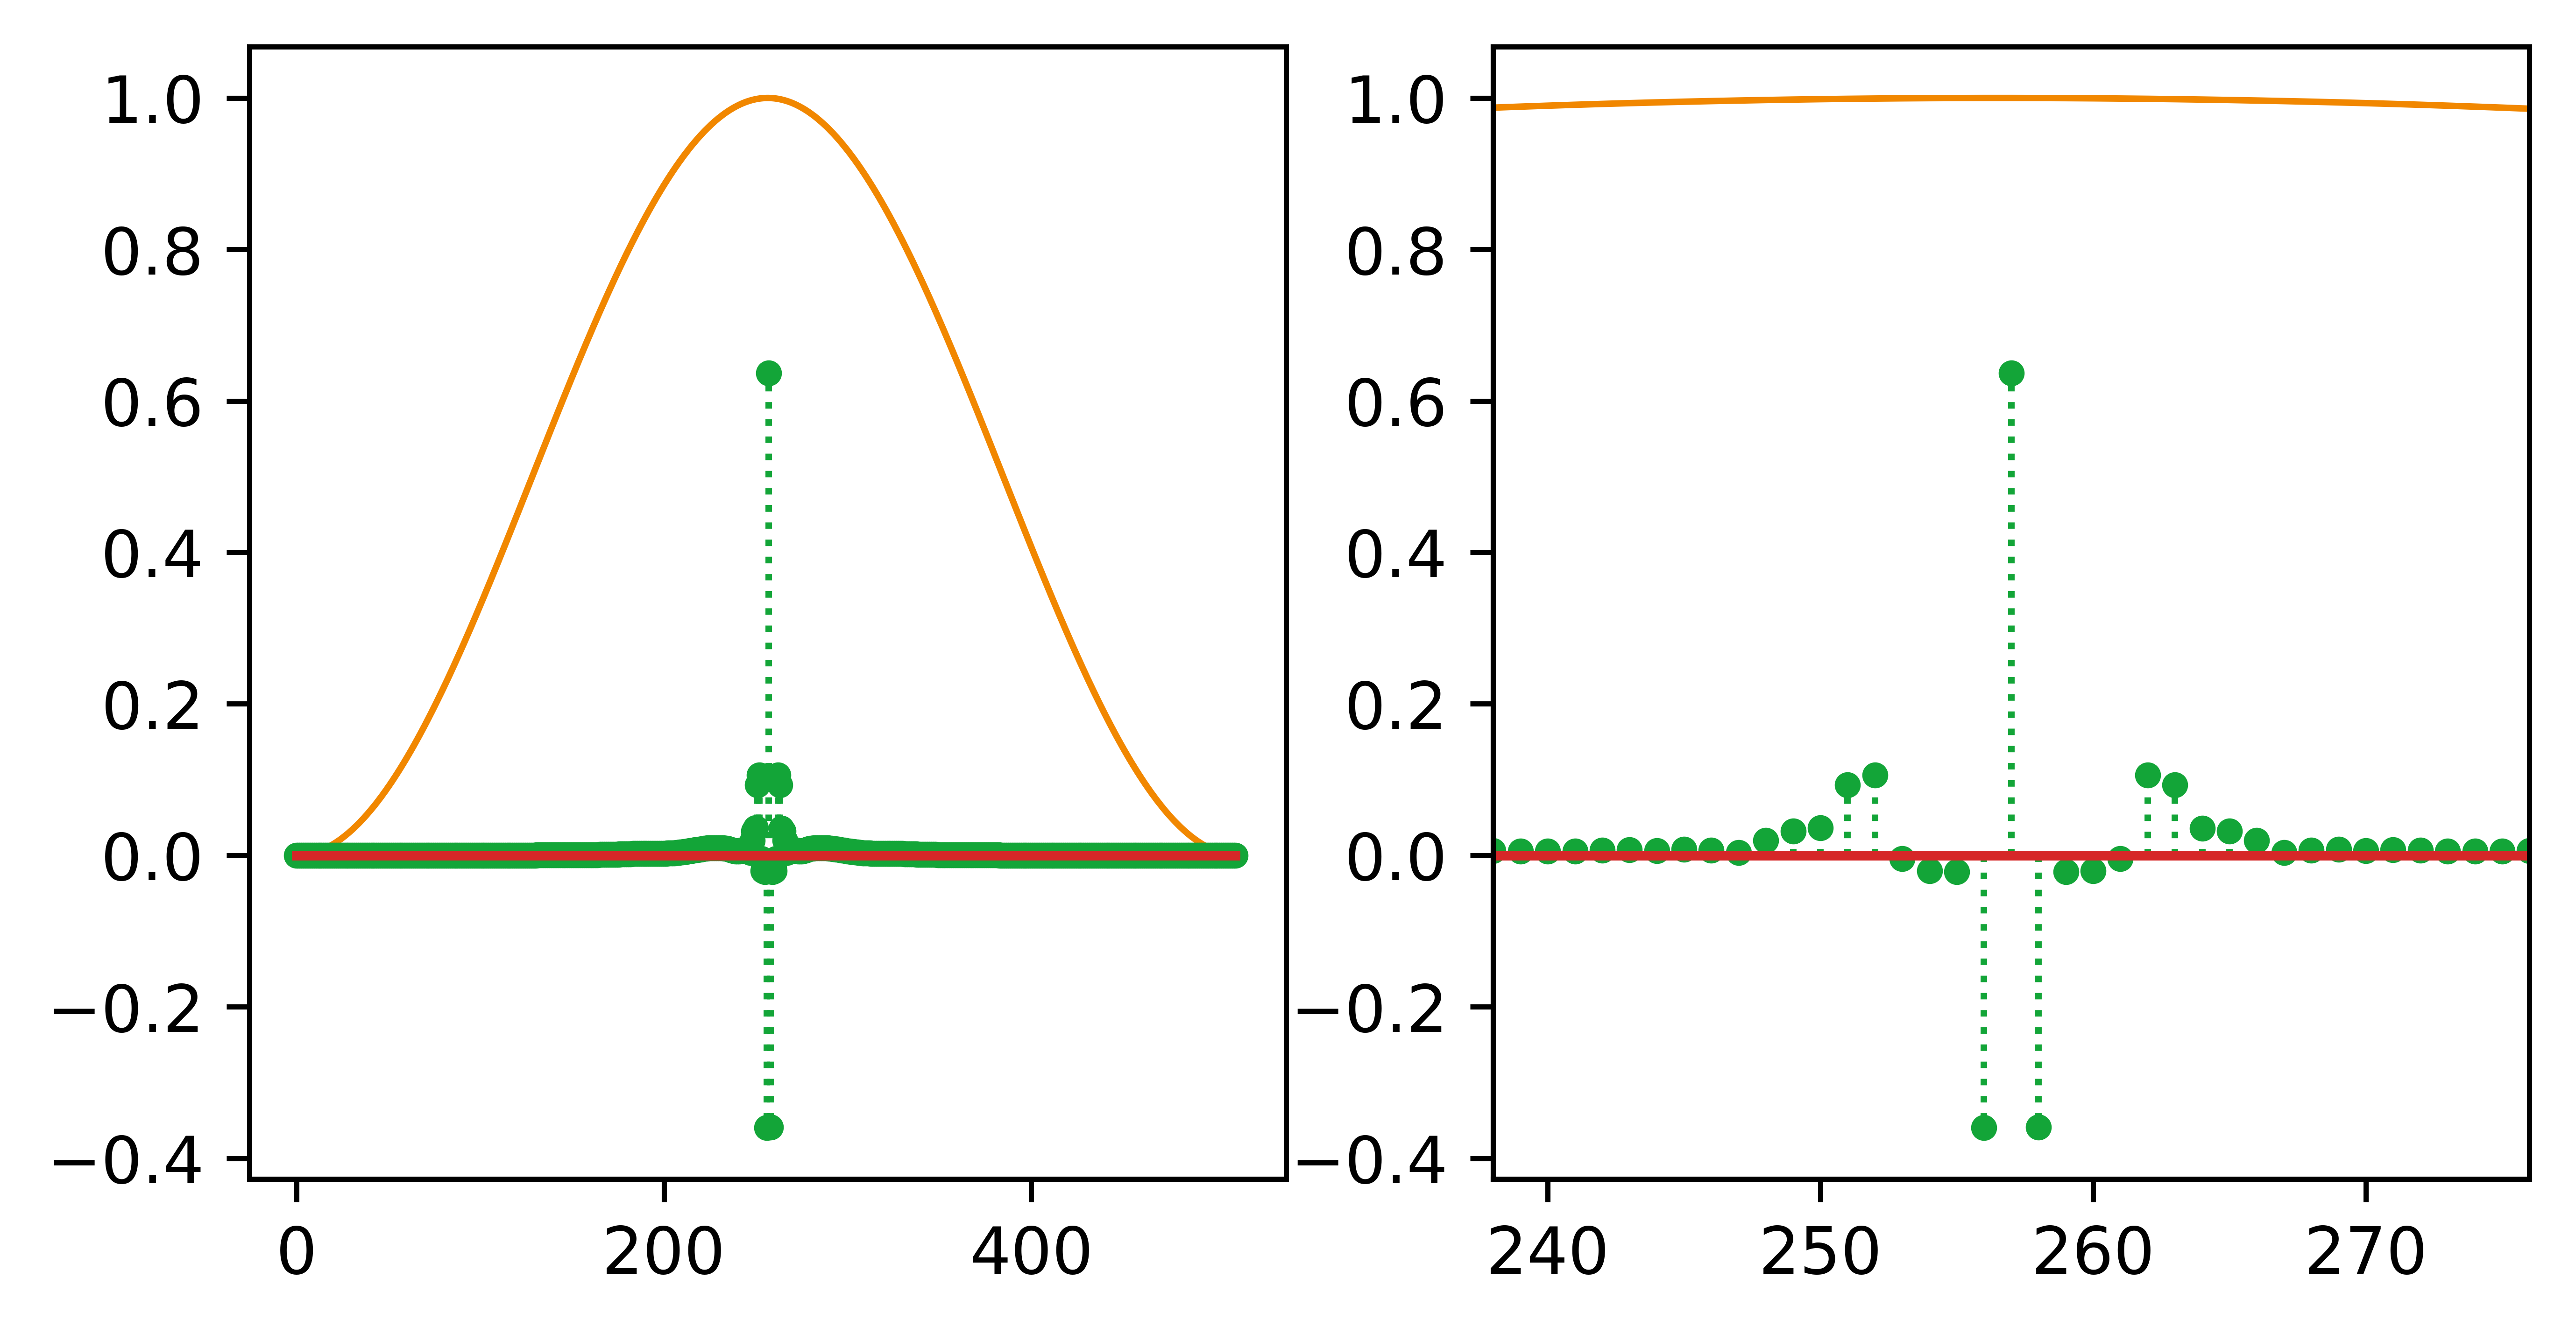

In [136]:
TAPS = len(kernel) # taps could be less than the generated kernel
tap_xspace = np.linspace(0, TAPS + 1, TAPS)

window = np.cos(np.linspace(-np.pi, np.pi, TAPS)) / 2 + 0.5
kernel = kernel * window

fig, axs = plt.subplots(1, 2)
axs[0].plot(tap_xspace, window, color="#f18700", lw=1)
markerline, stemlines, baseline = axs[0].stem(kernel, markerfmt=".")
plt.setp(markerline, 'color', "#13a538")
plt.setp(stemlines, 'color', "#13a538")
plt.setp(stemlines, 'linestyle', 'dotted')
plt.setp(stemlines, 'linewidth', 1)

axs[1].plot(tap_xspace, window, color="#f18700", lw=1)
markerline, stemlines, baseline = axs[1].stem(kernel, markerfmt=".")
plt.setp(markerline, 'color', "#13a538")
plt.setp(stemlines, 'color', "#13a538")
plt.setp(stemlines, 'linestyle', 'dotted')
plt.setp(stemlines, 'linewidth', 1)
axs[1].set_xlim([TAPS//2 -18, TAPS//2 + 20])

plt.show()

Die grünen Punkte repräsentieren die individuellen \gls{fir} Taps.
Die rote Linie ist die Baseline um 0 zur Referenz.
Das Fenster wird durch den orangen Plot gezeichnet.
Der linke Plot zeigt alle Taps.
Der rechte zeigt nur einen Ausschnitt um die Mitte zentriert.

Wie zu erwarten sind die Taps, wie bei einem \gls{fir} Filter zu erwarten, um $\frac{\texttt{N}}{2}$ zentriert.
Anders als der standardmäßige $\text{sinc} (x)$ Filter ist die maximale Amplitude jedoch $<1$.

## Demonstration des Filters

Um zu demonstrieren, dass der konstruierte Filter funktioniert, wird ein anschauliches Beispiel geliefert.
Ein Signal wird in hoher Bit-Tiefe erstellt.
Dieses wird folgend stark quantisiert.
Eine weitere Version dieses Signals wird mit subtraktivem \gls{tpdf} Dither versehen.
Anschließend wird eine weitere Kopie durch den erstellten Filter geformt.

### Testsignal

Im Folgenden wird ein einfaches Testsignal erstellt.
Dieses ist ein Sinus mit 100 Hertz bei einer Abtastrate $f_s$ von 48 Kilohertz über eine Sekunde.
Das Signal hat die allgemeine Form von
$$f(t) = \sin (2 \pi f t)$$

In [137]:
FS = 48000
frequency = 100
duration = 1
t = np.linspace(0, duration, FS * duration)
signal = (np.sin(frequency * 2 * np.pi * t))

Das Signal wird nun auf 16 Bit skaliert.
Es ist noch immer ein \gls{floating point} Wert.
Anschließend wird die Fourier Transformation des Signals gezeigt.
Darin ist ein klarer Hochpunkt bei $10^2$ Hertz zu erkennen.
Im Bereich darüber bis hin zur halben Abtastfrequenz befinden sich Konvertierungsartefakte, welche zu diesem Zeitpunkt ignoriert werden können.

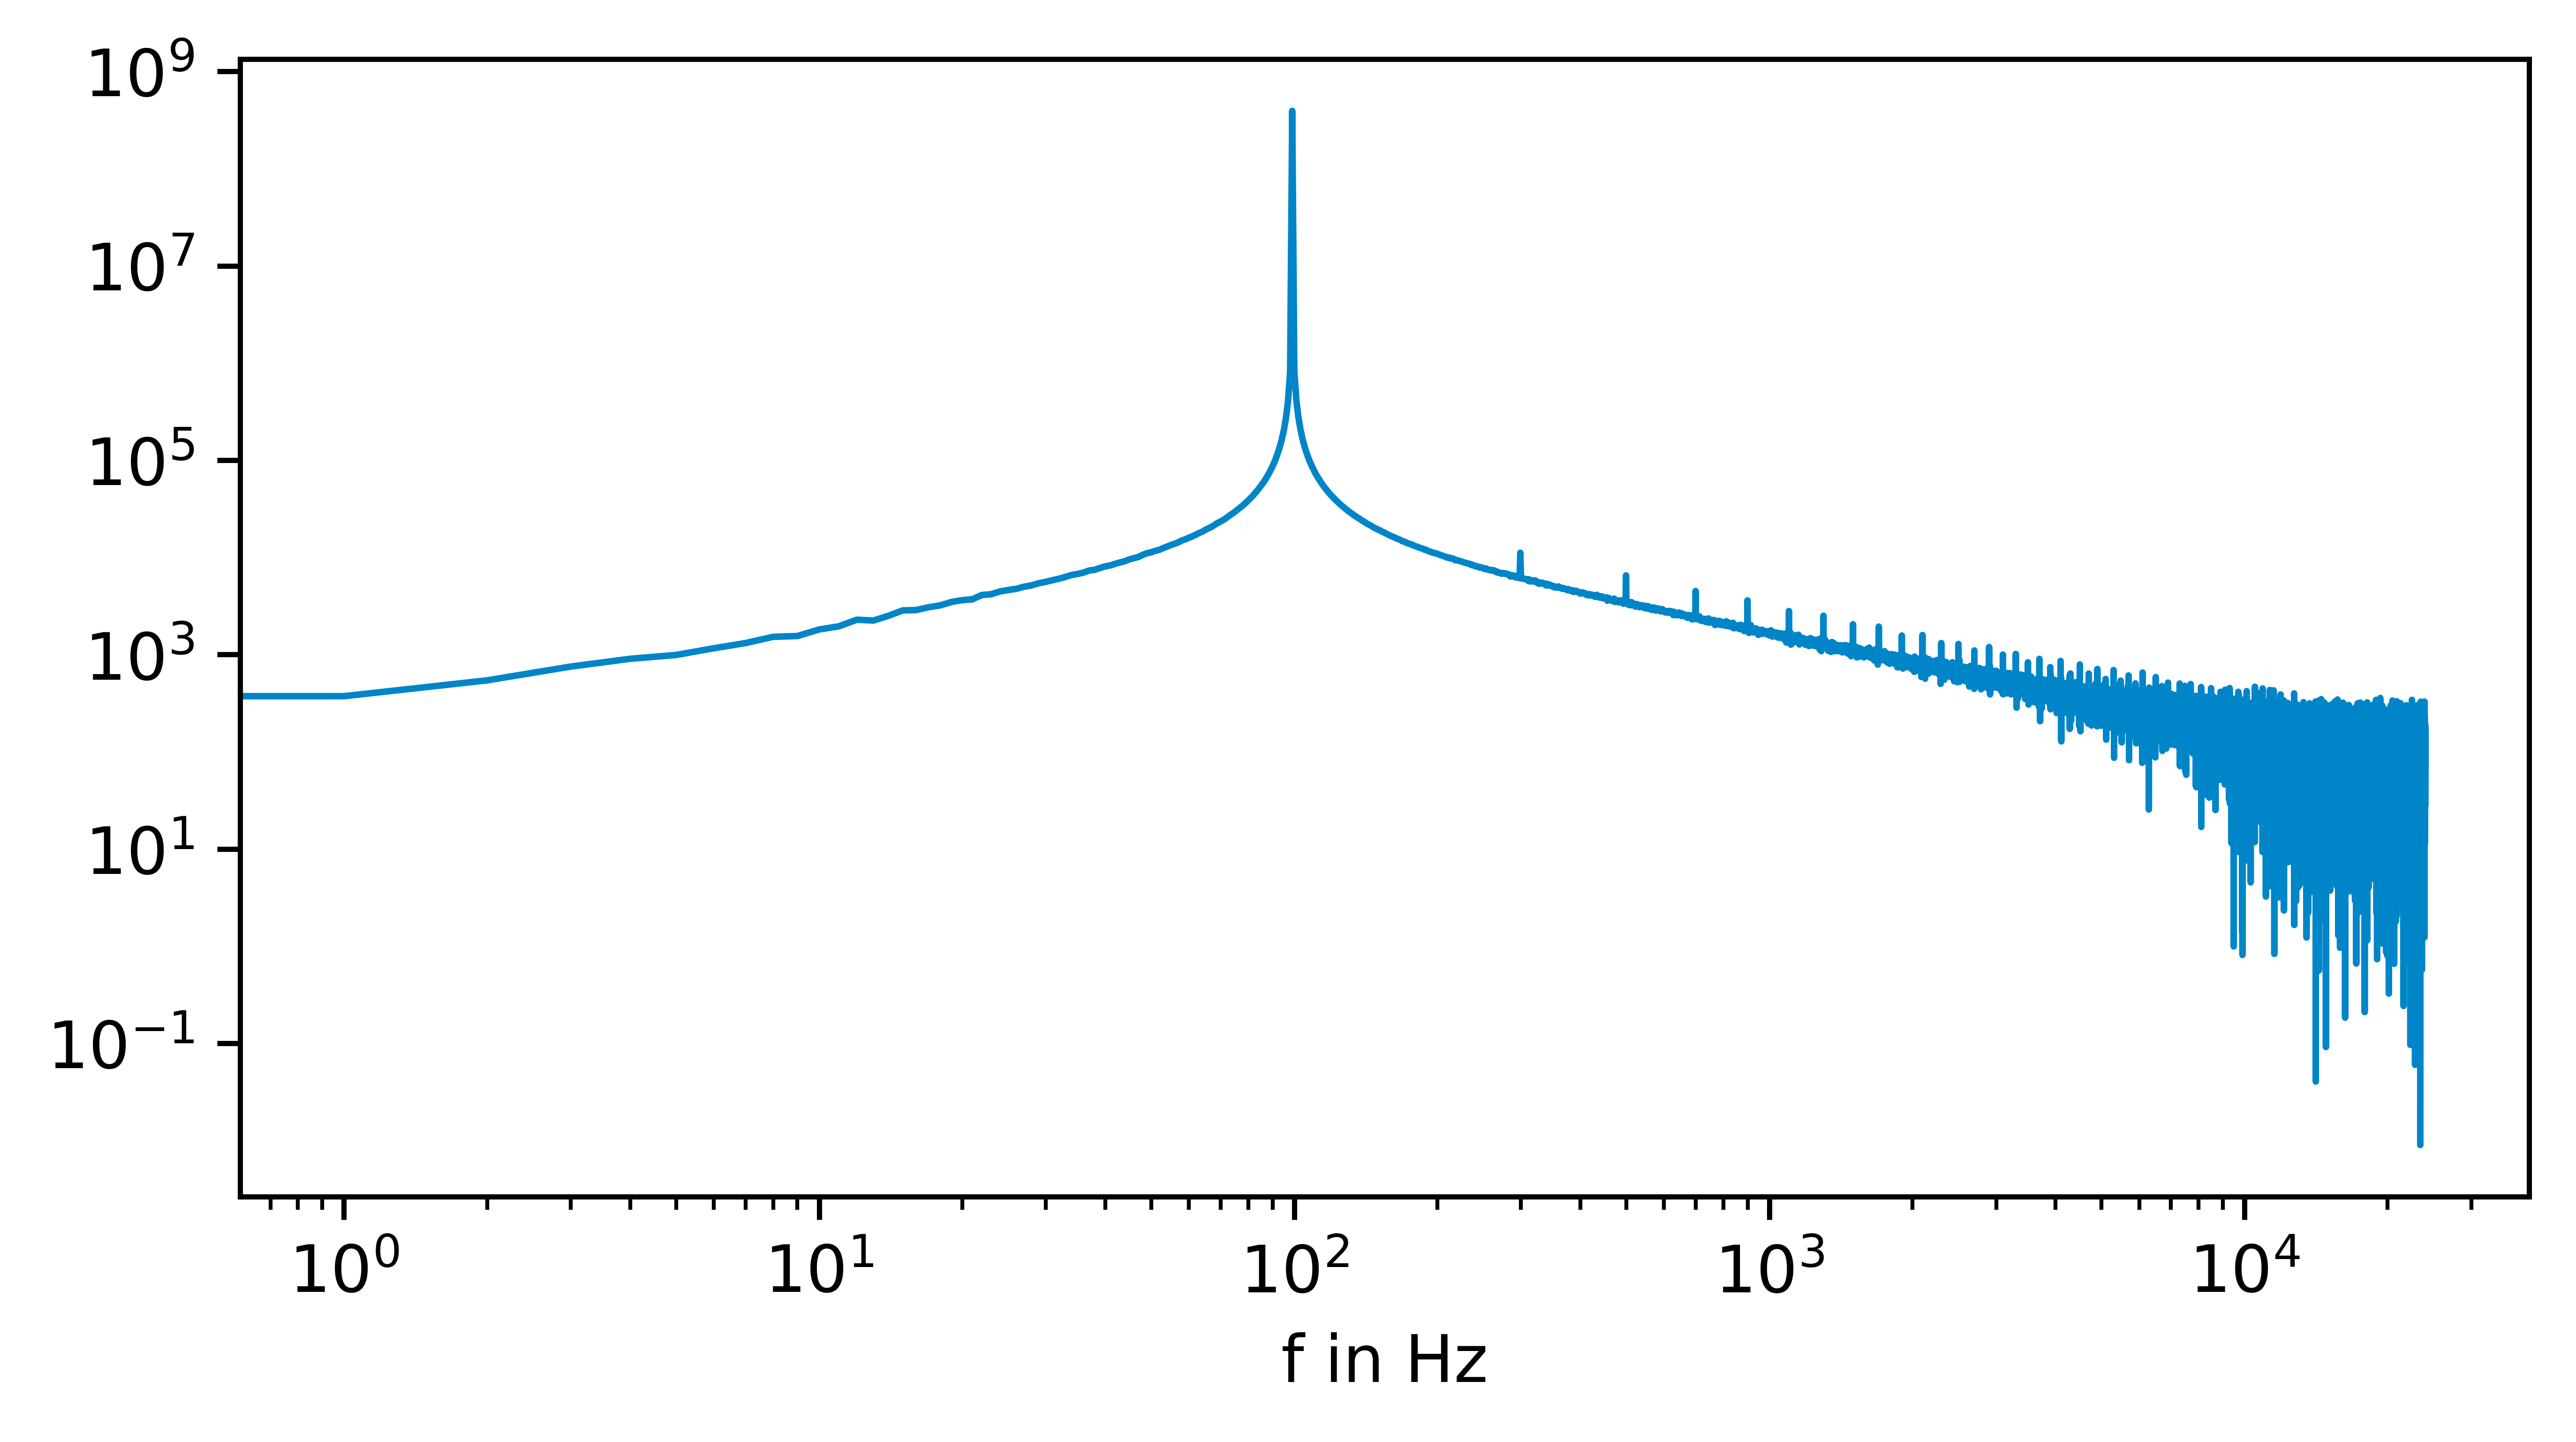

In [138]:
bits = 15 # 15 bits scale due to sign bit
scale = 2**(bits-1) # -1 for a bit headroom in anticipation of dither
signal_scaled = (scale * signal).astype(np.int16)

plt.plot(np.abs(fft(signal_scaled)[1:FS//2]), color="#0085c8", lw=1)
plt.loglog()
plt.xlabel("f in Hz")
ylim=plt.gca().get_ylim()
plt.show()

### Quantisierung und Dither

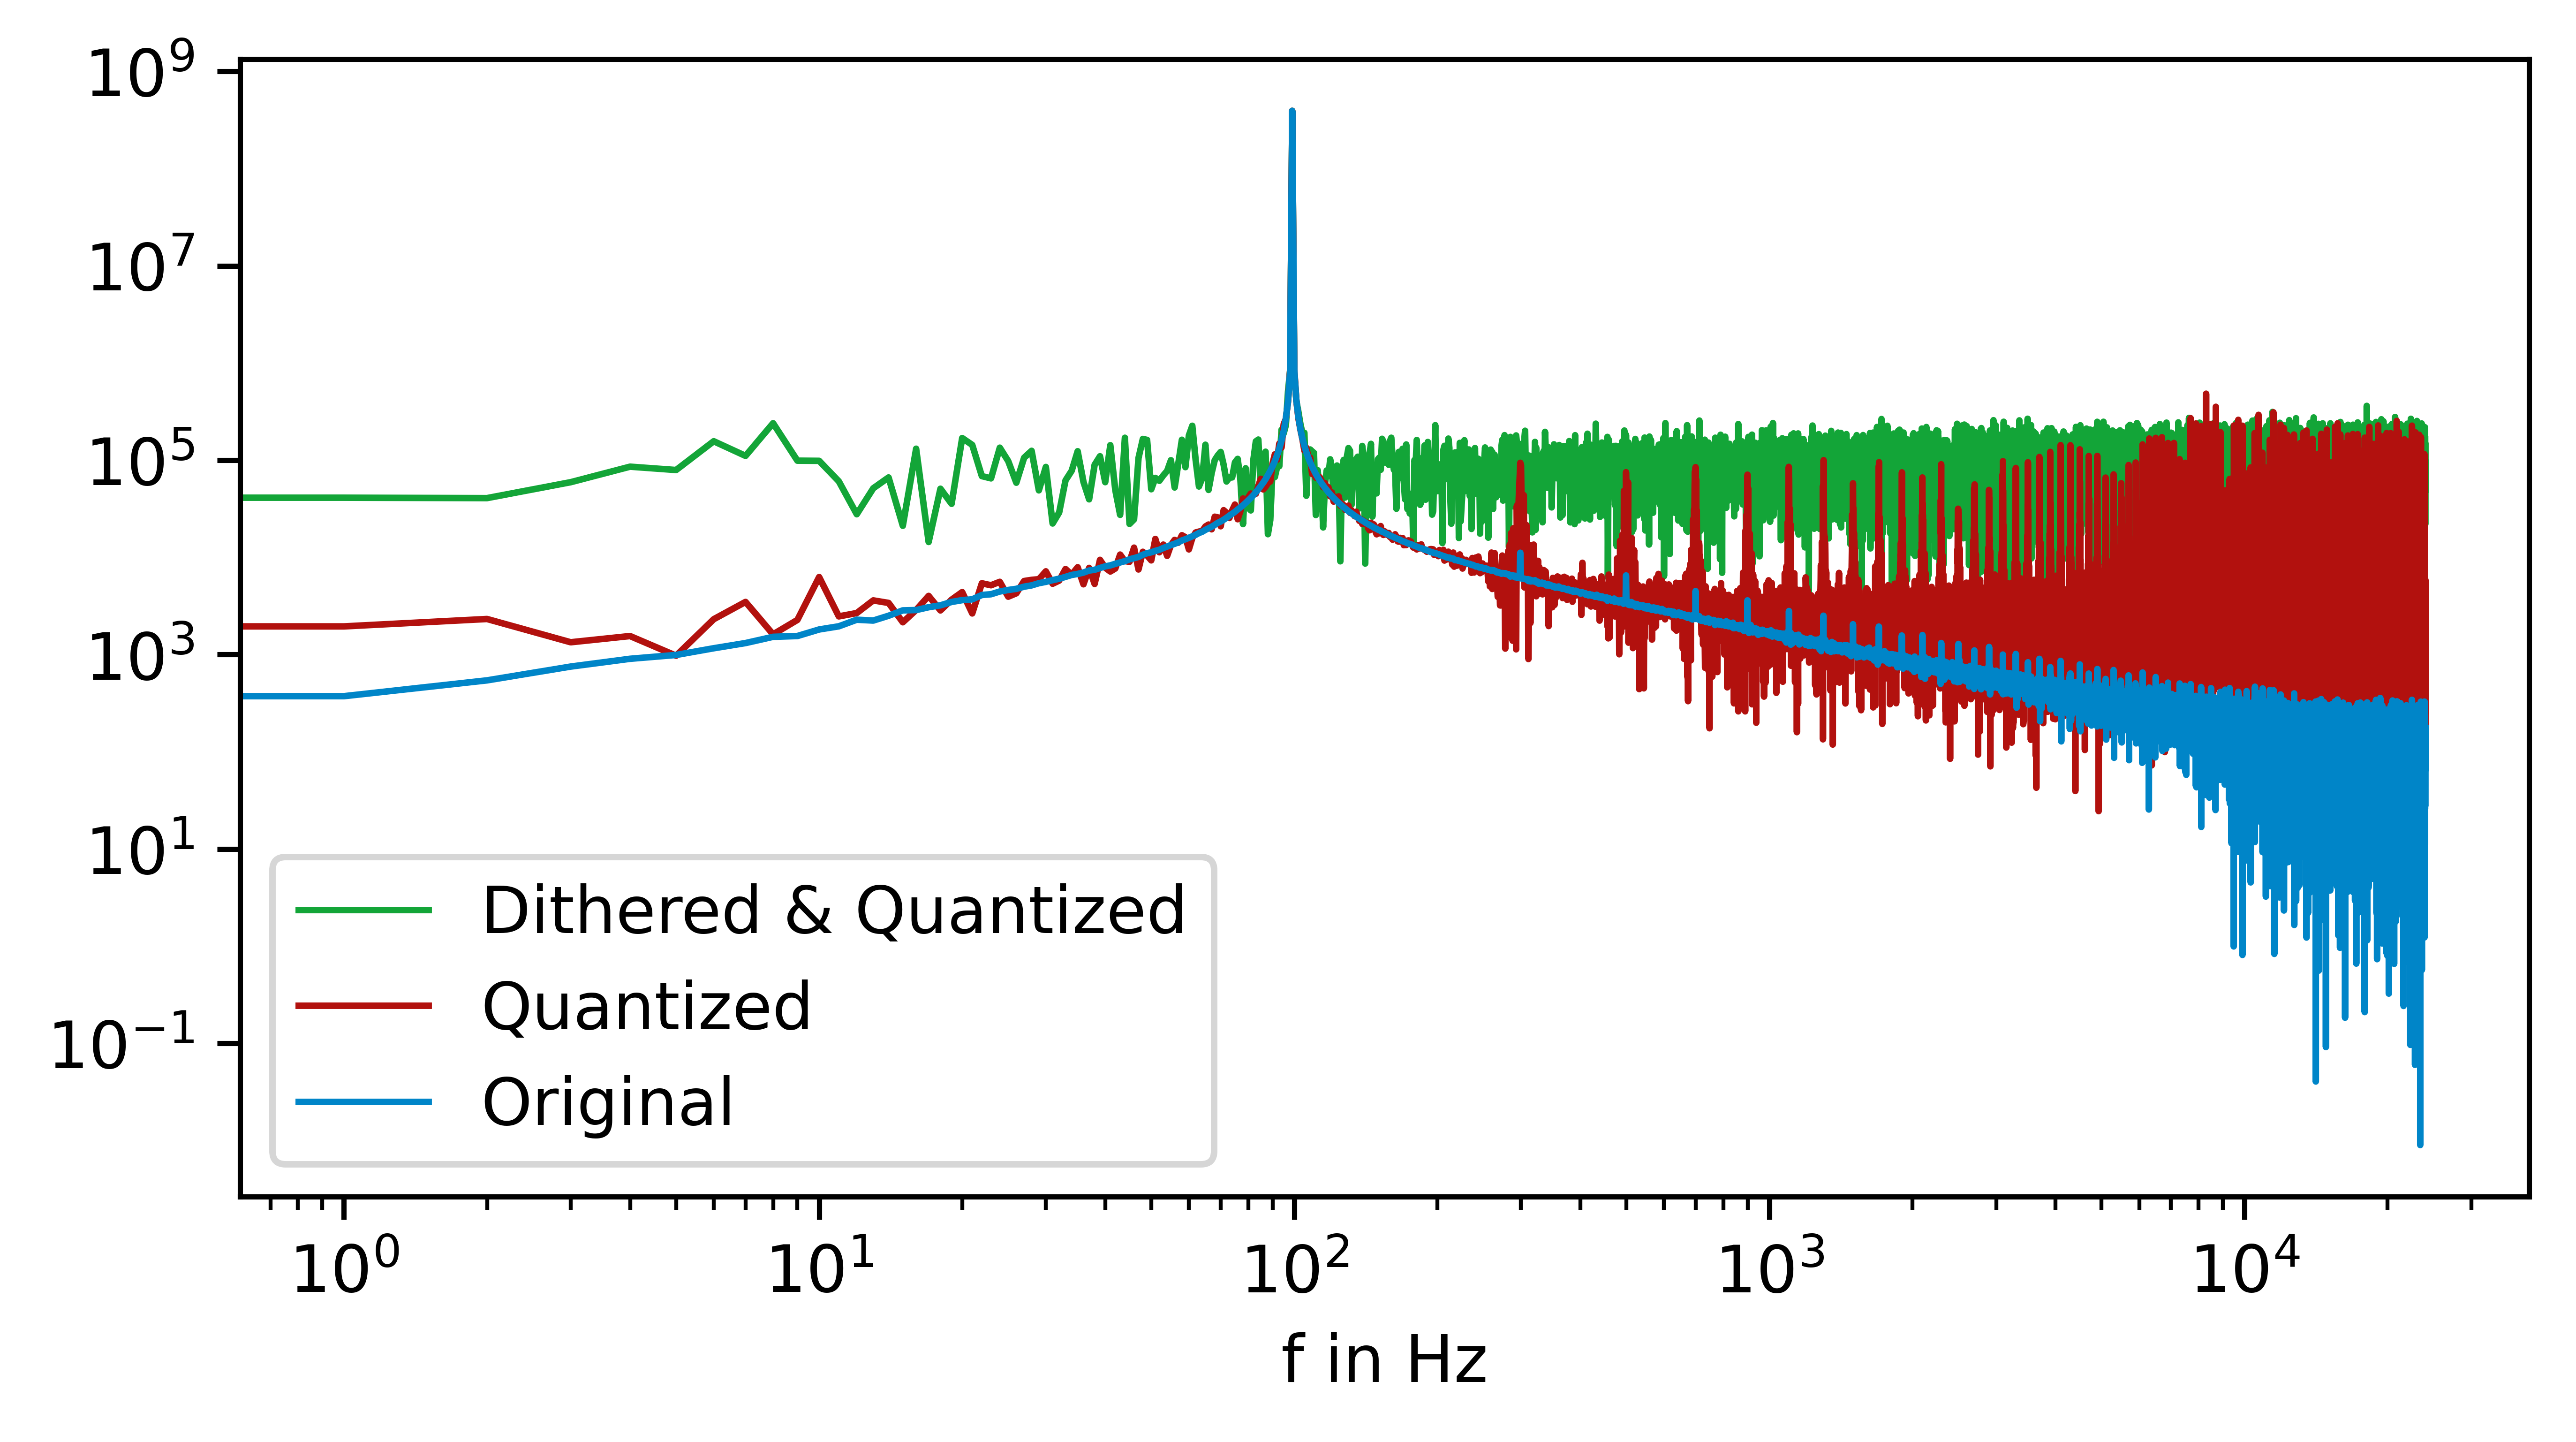

In [139]:
# TPDF dither using two uncorellated noise sources
dither = np.random.rand(len(signal)) + np.random.rand(len(signal))
dither_scaled = (dither * (2**10)).astype(np.int16) # scale dither (usually only to 1 LSB)

# apply dither
signal_scaled_dither = signal_scaled - dither_scaled

# quantization using a quantizer function
delta = (2**(8))
quantized_signal = delta * np.floor((signal_scaled / delta) + (1/2))
quantized_signal_dither = delta * np.floor((signal_scaled_dither / delta) + (1/2))

plt.plot(np.abs(fft(quantized_signal_dither)[1:FS//2]), color="#13a538", lw=1)
plt.plot(np.abs(fft(quantized_signal)[1:FS//2]), color="#b2110e", lw=1)
plt.plot(np.abs(fft(signal_scaled)[1:FS//2]), color="#0085c8", lw=1)

plt.legend([
    "Dithered & Quantized",
    "Quantized",
    "Original",
], loc="lower left")

plt.loglog()
plt.xlabel("f in Hz")
plt.gca().set_ylim(ylim)

plt.show()

Dieses überzogene Beispiel demonstriert das Quantisierungsrauschen und den Effekt des Dithers.
Jedes Signal zeigt noch immer den Ton bei 100 Herzt.
Das quantisierte Signal besitzt dazu einige harmonische Übertöne im Vergleich zum originalen.
Das Signal mit Dither hat keine Übertöne, dafür jedoch ein wesentlich reduziertes \gls{snr}. 

### Rauschformungsfilter Rückkopplungsschleife

Dieser Loop implementiert den gesamten Rauschformungsprozess.
Dieser muss aufgrund des Feedbacks für jedes Sample ausgerechnet werden und kann nicht als paralleler Prozess realisiert werden.
Ein Sample wird mit dem Feedback und Dither verrechnet und quantisiert.
Der Fehler aus dieser Operation wird berechnet.
Anschließend wird dieser Fehler durch Faltung gefiltert und rückgekoppelt.

In [140]:
quantized_signal_noise_shaped = [0] * len(signal)
filter_buffer = [0] * len(kernel)
filtered_error = 0

# Noise shaping feedback loop
for n in range(len(signal)):
    sample = signal_scaled[n] - filtered_error
    dithered_sample = sample - dither_scaled[n]
    quantized_sample = delta * np.floor((dithered_sample / delta) + (1/2))

    error = quantized_sample - sample
    filter_buffer.append(error)
    filtered_error = 0

    # Convolution
    for k in range(len(kernel)):
        filtered_error = filtered_error + filter_buffer[n-k] * kernel[k]

    quantized_signal_noise_shaped[n] = (sample)

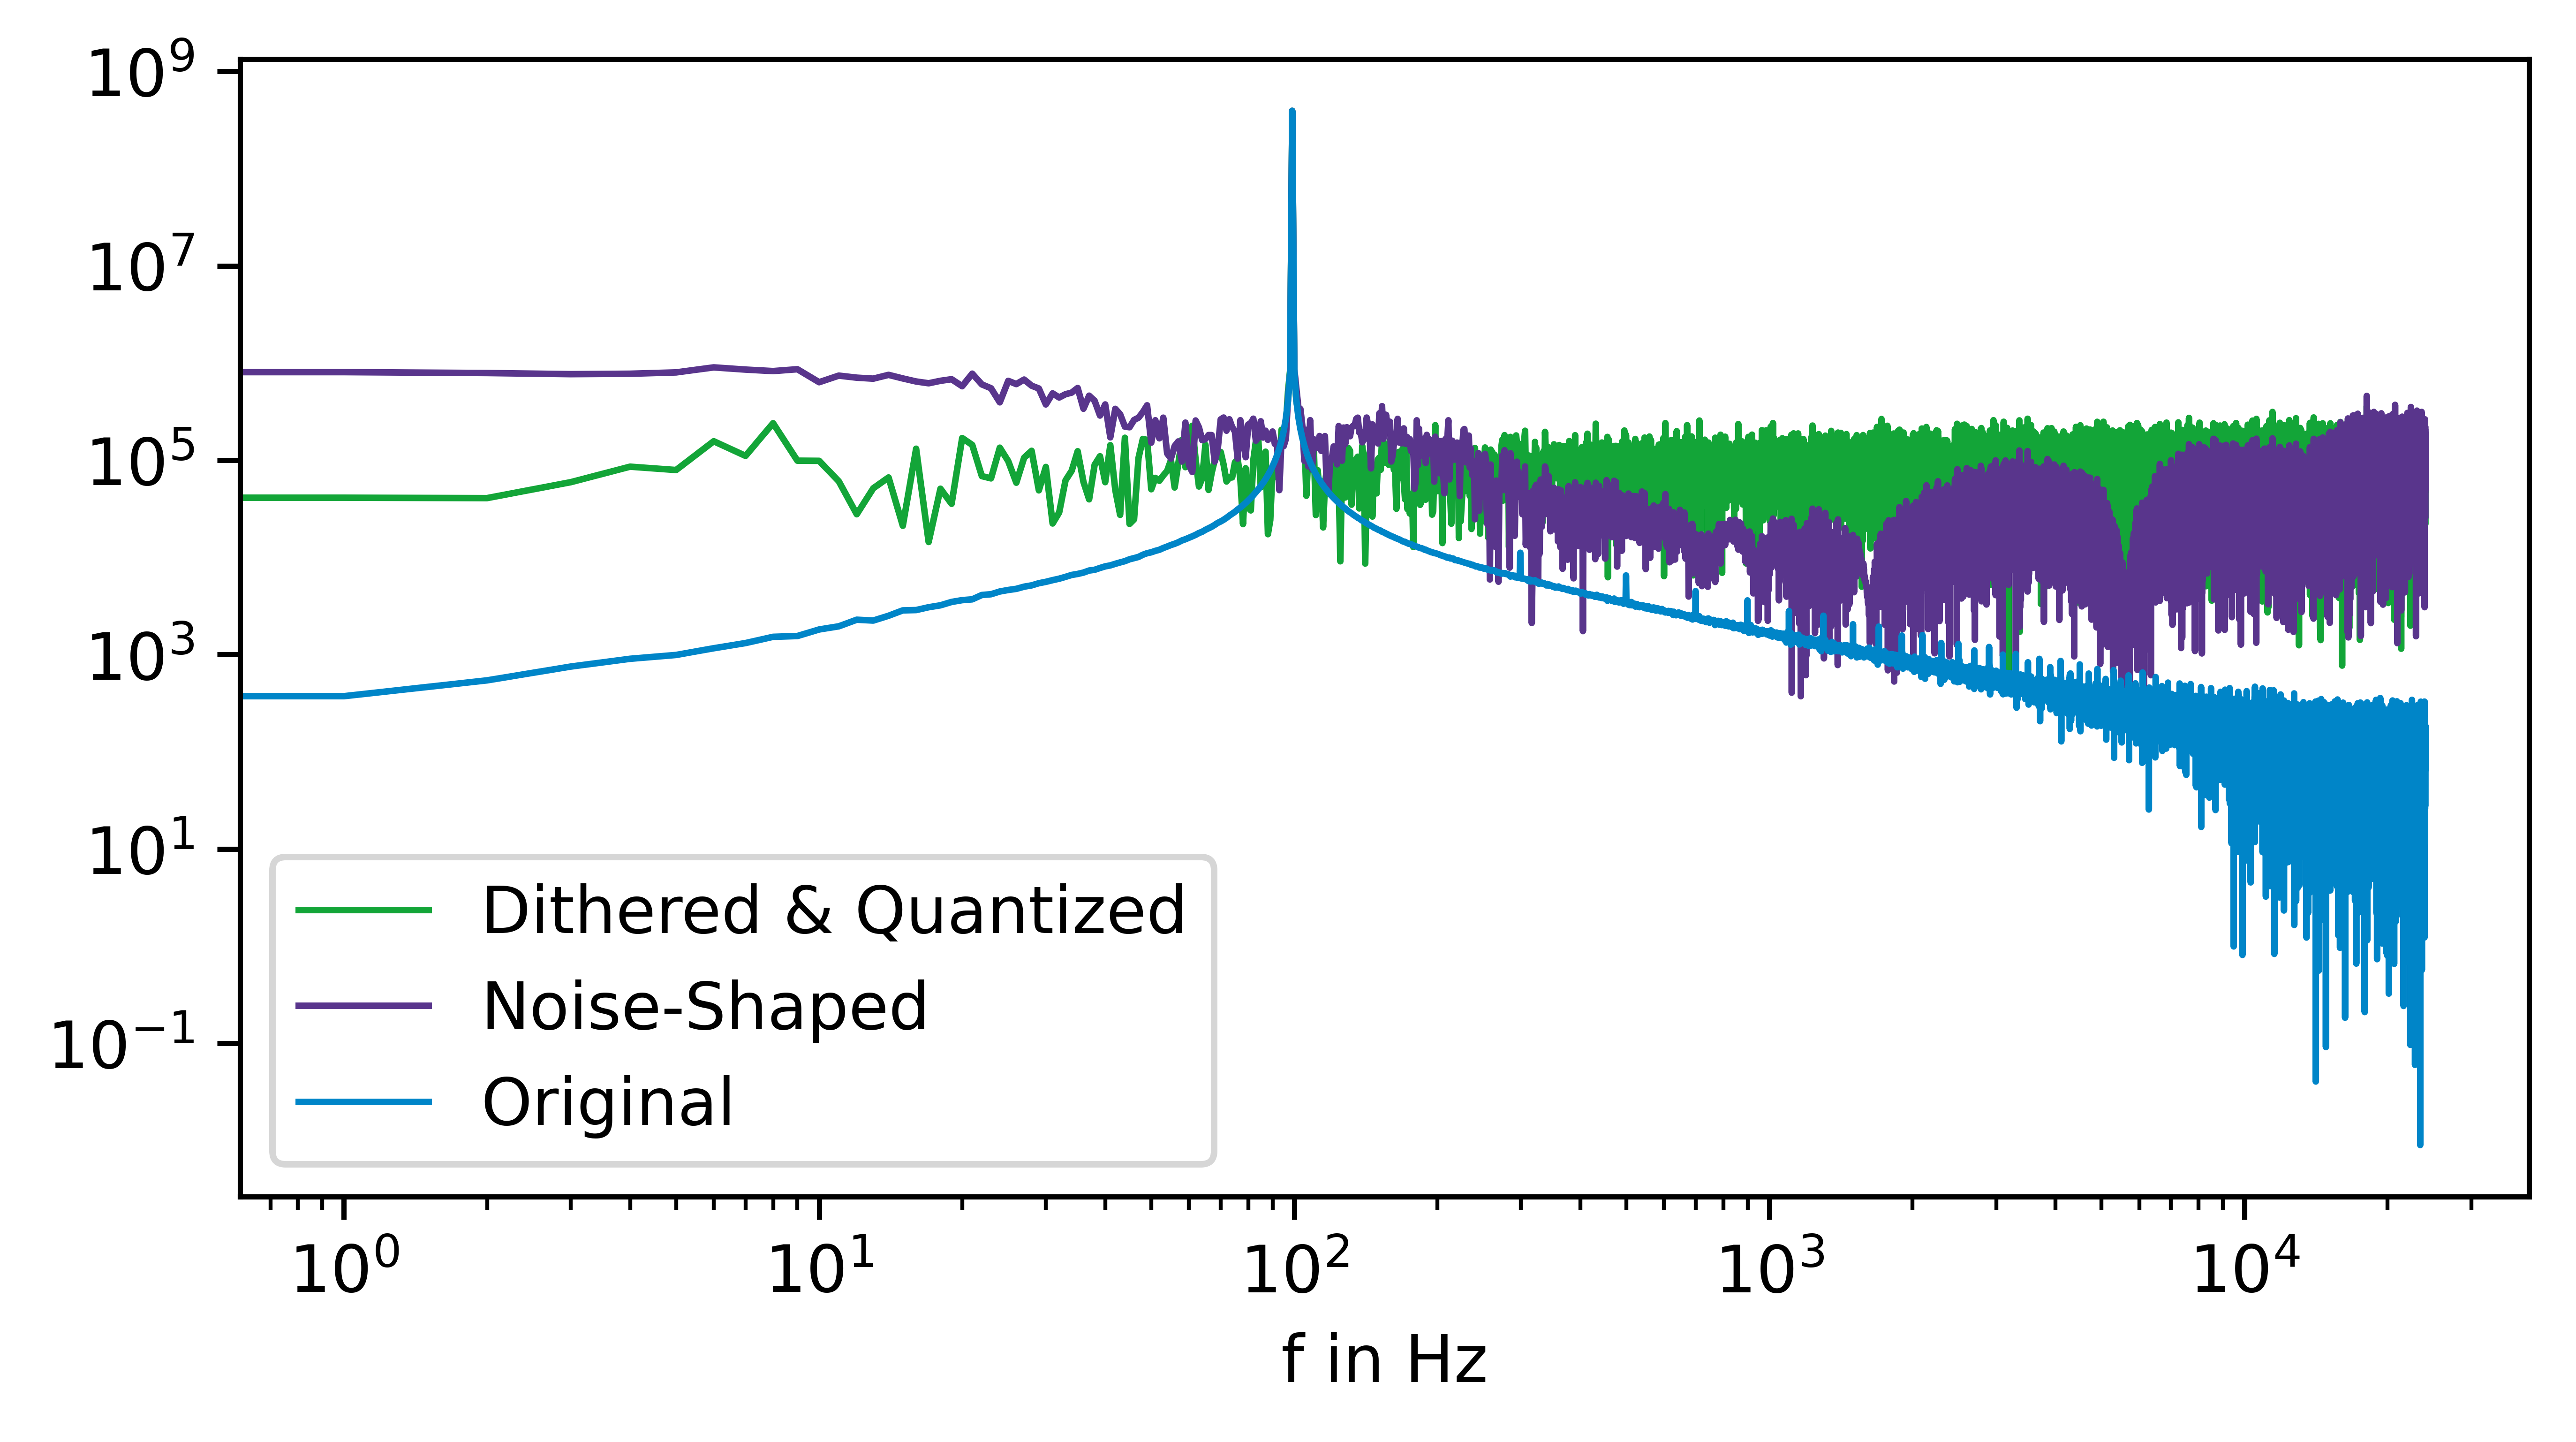

In [142]:
plt.plot(np.abs(fft(quantized_signal_dither)[1:FS//2]), color="#13a538", lw=1)
plt.plot(np.abs(fft(quantized_signal_noise_shaped)[1:FS//2]), color="#59358c", lw=1)
plt.plot(np.abs(fft(signal_scaled)[1:FS//2]), color="#0085c8", lw=1)

plt.legend([
    "Dithered & Quantized",
    "Noise-Shaped",
    "Original"
], loc="lower left")

plt.loglog()
plt.xlabel("f in Hz")
plt.gca().set_ylim(ylim)

plt.show()

In diesem Beispiel ist die spektrale Formung des Rauschens anschaulich demonstriert.
Der Effekt ist hier, wie schon mehrmals erwähnt, stark dramatisiert.
Das grundlegende Konzept ist jedoch auch in der realen Implementation identisch.

Das geformte Rauschen nimmt die Form der Zielfunktion an.
Es wird in Summe keine Energie zugefügt oder entzogen.
Der Rauschformungsfilter funktioniert.

\hfill$\blacksquare$